## 7. Mech Interp 1

In [1]:
# from huggingface_hub import hf_hub_download, notebook_login
# notebook_login()

In [2]:
# !pip install "torch>=2.1.0" einops datasets jaxtyping "sae_lens==3.23.1" openai tabulate "nbformat>=4.2.0" umap-learn hdbscan eindex-callum git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python git+https://github.com/callummcdougall/sae_vis.git@callum/v3 "transformer-lens>=2.7.0"

In [1]:
from IPython.display import HTML, IFrame, clear_output, display
import random
from rich import print as rprint
from rich.table import Table
from tqdm.auto import tqdm
from functools import partial
import torch as t
import torch.nn.functional as F
from torch import Tensor, nn
from jaxtyping import Float, Int
import einops

import matplotlib.pyplot as plt
import numpy as np

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)

from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from tabulate import tabulate

import pickle, glob

In [2]:
gemmascope_sae_release = "gemma-scope-2b-pt-mlp-canonical"
gemmascope_sae_id = "layer_20/width_16k/canonical"

In [3]:
gemma_2_2b = HookedSAETransformer.from_pretrained("gemma-2-2b", device=device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [4]:
gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]

In [5]:
prompt = "The reliability of Wikipedia is very"
answer = " high"

In [6]:
utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 2        Logit: 25.30 Prob: 11.16% Token: | high|

Top 0th token. Logit: 25.89 Prob: 20.21% Token: | important|
Top 1th token. Logit: 25.41 Prob: 12.50% Token: | much|
Top 2th token. Logit: 25.30 Prob: 11.16% Token: | high|
Top 3th token. Logit: 25.27 Prob: 10.80% Token: | low|
Top 4th token. Logit: 25.14 Prob:  9.48% Token: | questionable|
Top 5th token. Logit: 24.59 Prob:  5.47% Token: | poor|
Top 6th token. Logit: 24.40 Prob:  4.55% Token: | good|
Top 7th token. Logit: 23.56 Prob:  1.96% Token: | well|
Top 8th token. Logit: 23.51 Prob:  1.87% Token: | controversial|
Top 9th token. Logit: 23.24 Prob:  1.42% Token: | often|


Ranks of the answer tokens: [(' high', 2)]

In [7]:
tokens=gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)

In [8]:
#Now doing this mapping manually, should match outputs above, just less cool printout, do I need softcap here?
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)

for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2021
 much 0.125
 high 0.1116
 low 0.108
 questionable 0.0948
 poor 0.0547
 good 0.0455
 well 0.0196
 controversial 0.0187
 often 0.0142


## Longer Generation

In [9]:
prompt_2= "The reliability of Wikipedia is very important"

In [10]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)
gemma_2_2b.generate(prompt_2, max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very important for the success of its users. Therefore, it is necessary to maintain the quality of Wikipedia content. The aim of this paper was to examine the relationship between Wikipedia editors’ self-reported motivation and their contribution to improving the quality of content on Wikipedia.'

In [13]:
# Intrudction tuned Gemma
# gemma_2_2b_it = HookedSAETransformer.from_pretrained("gemma-2-2b-it", device=device)

## Visualize Data Moving Through model

In [25]:
prompt = "The reliability of Wikipedia is very"

In [26]:
tokens=gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)

In [27]:
cache['hook_embed'].shape

torch.Size([7, 2304])

In [28]:
t.testing.assert_close(cache['hook_embed'], cache['blocks.0.hook_resid_pre'])

In [29]:
m=cache['hook_embed'].detach().cpu().numpy()[-1,:].reshape(48,48)

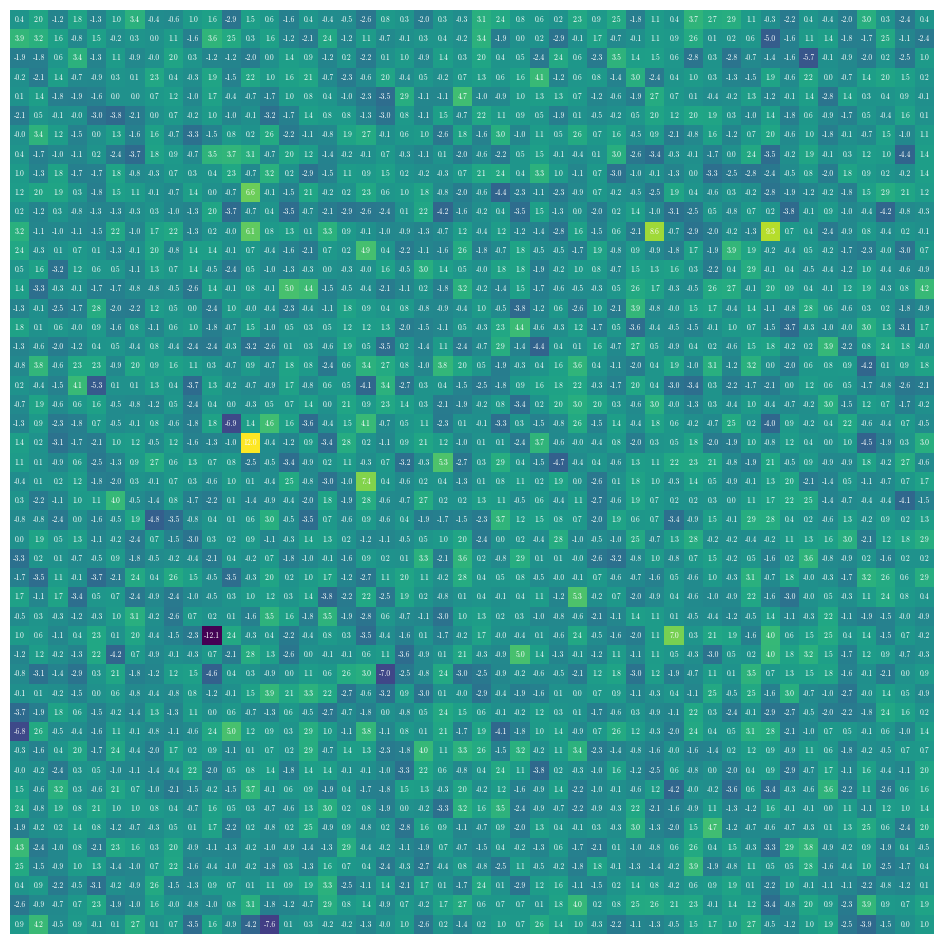

In [30]:
fig=plt.figure(0, (12,12))
ax=fig.add_subplot(111)
plt.imshow(m); 
#plt.colorbar()

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        ax.text(
            j, i, f"{m[i, j]:.1f}",
            ha="center", va="center",
            color="white", fontsize=5.5, 
            fontname="cmr10",
        )
plt.axis('off')
plt.savefig('/home/stephen/book_exports/7_mech_interp/gemma_layer_1.png', dpi=600, bbox_inches='tight')

In [ ]:
fig=plt.figure(0, (12,12))
ax=fig.add_subplot(111)
plt.imshow(m); 
#plt.colorbar()

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        ax.text(
            j, i, f"{m[i, j]:.1f}",
            ha="center", va="center",
            color="white", fontsize=5.5, 
            fontname="cmr10",
        )
plt.axis('off')
plt.savefig('/home/stephen/book_exports/7_mech_interp/gemma_layer_1.png', dpi=600, bbox_inches='tight')

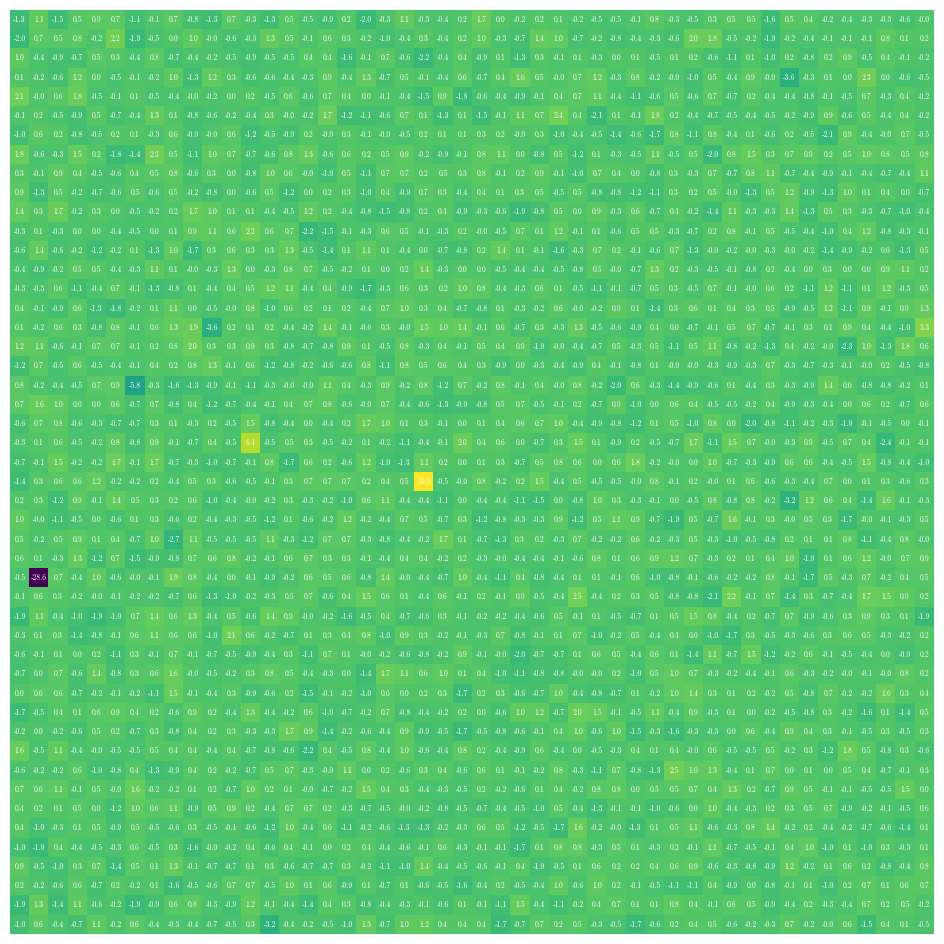

In [33]:
m=cache['ln_final.hook_normalized'].detach().cpu().numpy()[-1,:].reshape(48,48)

fig=plt.figure(0, (12,12))
ax=fig.add_subplot(111)
plt.imshow(m); 
#plt.colorbar()

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        ax.text(
            j, i, f"{m[i, j]:.1f}",
            ha="center", va="center",
            color="white", fontsize=5.5,fontname="cmr10"
        )
plt.axis('off')
plt.savefig('/home/stephen/book_exports/7_mech_interp/gemma_final_layer_1.png', dpi=600, bbox_inches='tight')

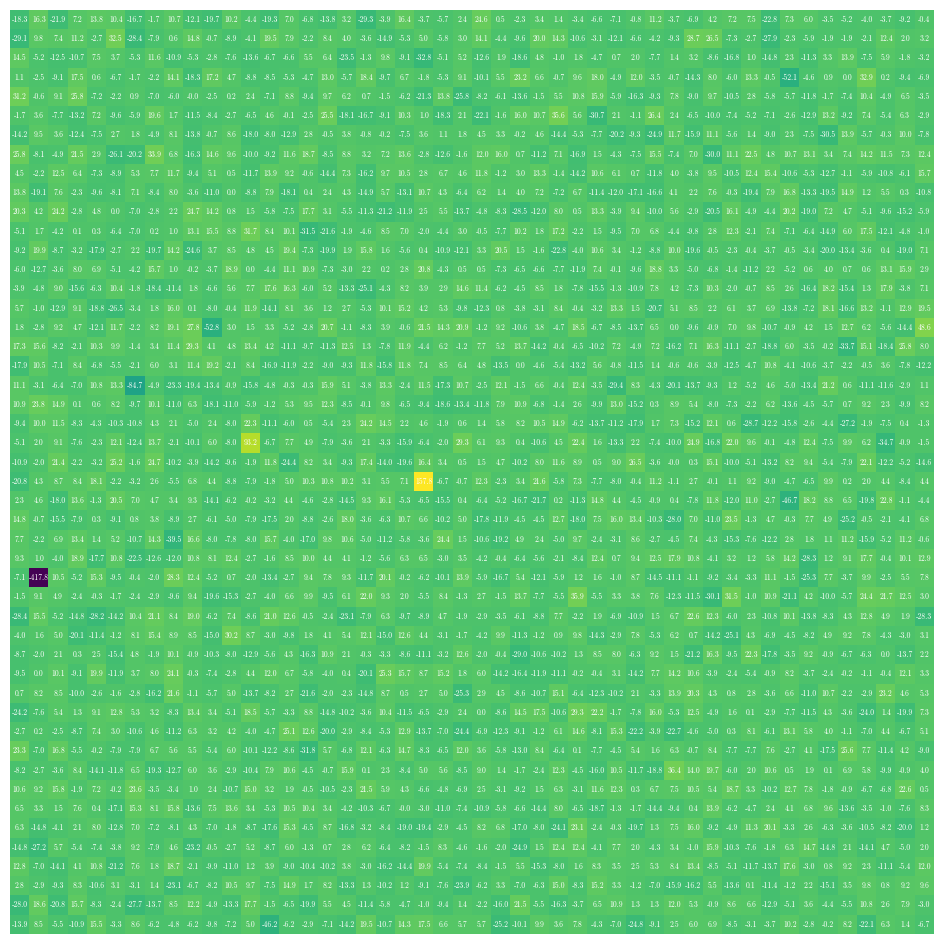

In [34]:
m=cache['blocks.25.hook_resid_post'].detach().cpu().numpy()[-1,:].reshape(48,48)

fig=plt.figure(0, (12,12))
ax=fig.add_subplot(111)
plt.imshow(m); 
#plt.colorbar()

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        ax.text(
            j, i, f"{m[i, j]:.1f}",
            ha="center", va="center",
            color="white", fontsize=5.5,fontname="cmr10"
        )
plt.axis('off')
plt.savefig('/home/stephen/book_exports/7_mech_interp/gemma_final_layer_b.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_177661/1773891996.py:5: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (4,4))


<Figure size 640x480 with 0 Axes>

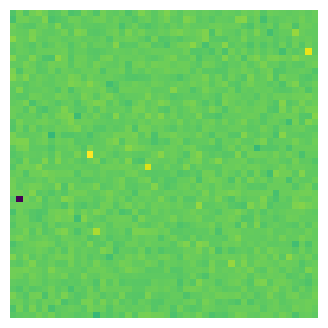

In [43]:
for layer_id in range(26):
    m=cache['blocks.'+str(layer_id)+'.hook_resid_pre'].detach().cpu().numpy()[-1,:].reshape(48,48)
    
    plt.clf()
    fig=plt.figure(0, (4,4))
    ax=fig.add_subplot(111)
    plt.imshow(m); 
    plt.axis('off')
    plt.savefig('/home/stephen/book_exports/7_mech_interp/hook_resid_pre'+str(layer_id).zfill(2)+'.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_177661/3359101116.py:5: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (4,4))


<Figure size 640x480 with 0 Axes>

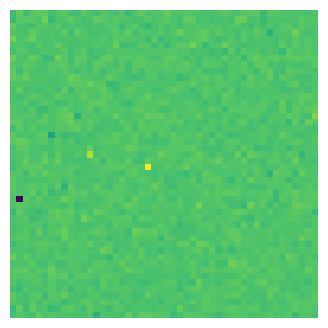

In [42]:
for layer_id in range(26):
    m=cache['blocks.'+str(layer_id)+'.hook_resid_post'].detach().cpu().numpy()[-1,:].reshape(48,48)
    
    plt.clf()
    fig=plt.figure(0, (4,4))
    ax=fig.add_subplot(111)
    plt.imshow(m); 
    plt.axis('off')
    plt.savefig('/home/stephen/book_exports/7_mech_interp/hook_resid_post_'+str(layer_id).zfill(2)+'.png', dpi=600, bbox_inches='tight')

## Work on table 

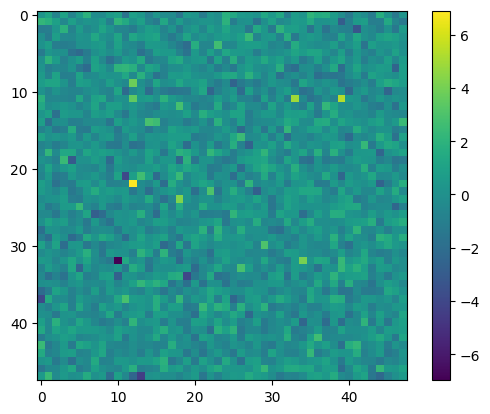

In [12]:
#Before model
activations_norm_ln_final=gemma_2_2b.ln_final(cache['hook_embed'])
m=activations_norm_ln_final.detach().cpu().numpy()[-1,:]
plt.imshow(m.reshape(48,48)); plt.colorbar()

In [16]:
my_logits = gemma_2_2b.unembed(activations_norm_ln_final)
my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(my_logits / gemma_2_2b.cfg.output_logits_soft_cap)
# my_logits_softcap=my_logits

probs=my_logits_softcap.softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
  print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 very 0.006
very 0.006
 Very 0.006
Very 0.006
 VERY 0.006
 très 0.006
 muy 0.006
VERY 0.006
 extremely 0.006
 sehr 0.0059


In [7]:
tokens=gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)
all_res=[]

for layer_id in range(25):
  activations_norm_next_layer=cache['blocks.'+str(layer_id+1)+'.ln1.hook_normalized']
  # activations_norm_ln_final=gemma_2_2b.ln_final(activations)

  my_logits = gemma_2_2b.unembed(activations_norm_next_layer)
  my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(my_logits / gemma_2_2b.cfg.output_logits_soft_cap)
  # my_logits_softcap=my_logits

  probs=my_logits_softcap.softmax(dim=-1)
  token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
  res={}
  for tk, p in zip(token_ids, token_probs):
    res[gemma_2_2b.to_string(tk.item())] = round(p.item(), 4)
  all_res.append(res)
  # print(layer_id, res)

#Final outputs
probs=logits.softmax(dim=-1)
token_probs, token_ids = probs[0,-1, :].topk(10, dim=-1)
res={}
for tk, p in zip(token_ids, token_probs):
  res[gemma_2_2b.to_string(tk.item())] = round(p.item(), 4)
all_res.append(res)
# print(layer_id+1, res)

In [11]:
all_res

[{' very': 0.0161,
  'very': 0.0161,
  'Very': 0.0161,
  ' Very': 0.0161,
  ' VERY': 0.016,
  'VERY': 0.0159,
  ' très': 0.0158,
  ' muy': 0.0158,
  ' sehr': 0.0154,
  ' extremely': 0.0151},
 {' very': 0.0254,
  'very': 0.0253,
  'Very': 0.0253,
  ' Very': 0.0252,
  ' VERY': 0.0249,
  'VERY': 0.0245,
  ' muy': 0.024,
  ' très': 0.0239,
  ' sehr': 0.0225,
  ' очень': 0.0212},
 {' very': 0.0309,
  'Very': 0.03,
  'very': 0.0299,
  ' Very': 0.0299,
  ' VERY': 0.0291,
  'VERY': 0.028,
  ' très': 0.025,
  ' muy': 0.0246,
  ' sehr': 0.0239,
  ' extremely': 0.0217},
 {' very': 0.0976,
  'Very': 0.0802,
  'very': 0.0779,
  ' Very': 0.075,
  ' VERY': 0.0687,
  'VERY': 0.0575,
  ' très': 0.0404,
  ' muy': 0.04,
  ' sehr': 0.0326,
  ' quite': 0.0292},
 {' very': 0.1365,
  'Very': 0.0968,
  ' Very': 0.0898,
  'very': 0.087,
  ' VERY': 0.0842,
  'VERY': 0.0643,
  ' très': 0.0301,
  ' muy': 0.0285,
  ' sehr': 0.0241,
  'Очень': 0.0232},
 {'<bos>': 0.3661,
  ' very': 0.3139,
  'Very': 0.0688,
  ' Ver

In [10]:
import pandas as pd
import json

keys_data = []
for d in all_res:
    # Add quotes around each token to preserve spacing visibility
    row = [f'"{key}"' for key in d.keys()]
    keys_data.append(row)

# Extract values (probabilities)
values_data = []
for d in all_res:
    row = list(d.values())
    values_data.append(row)

# Create DataFrames
# For keys, we need to handle variable column counts
max_cols = max(len(row) for row in keys_data)
keys_df = pd.DataFrame(keys_data, columns=[f'Token_{i+1}' for i in range(max_cols)])

# For values
values_df = pd.DataFrame(values_data, columns=[f'Prob_{i+1}' for i in range(max_cols)])

# Save to CSV
keys_df.to_csv('/home/stephen/book_exports/7_mech_interp/tokens_keys_2.csv', index=False)
values_df.to_csv('/home/stephen/book_exports/7_mech_interp/tokens_values_2.csv', index=False)

### Output we "do surgery on"

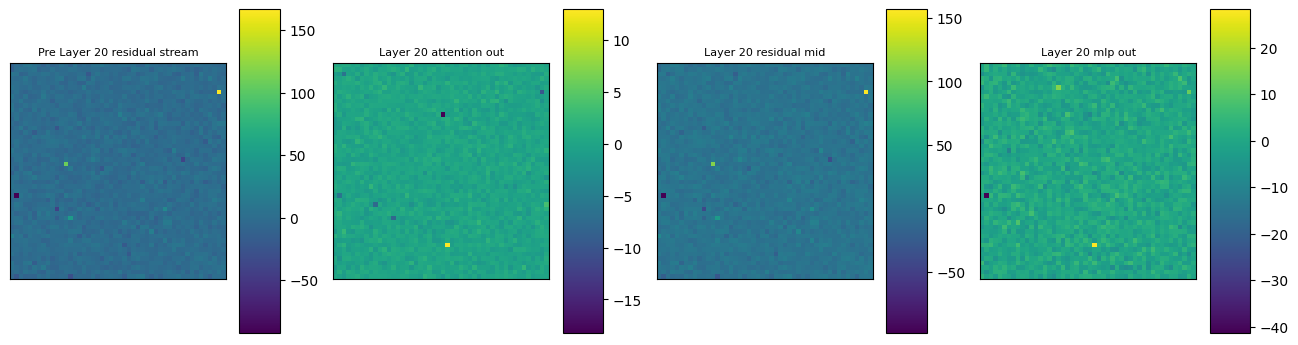

In [17]:
layer_id=20
subplot_rows=1

residual_stream=cache['blocks.'+str(layer_id)+'.hook_resid_pre'].detach().cpu().numpy()
attn_out=cache['blocks.'+str(layer_id)+'.hook_attn_out'].detach().cpu().numpy()
residual_stream_mid=cache['blocks.'+str(layer_id)+'.hook_resid_mid'].detach().cpu().numpy()
mlp_out=cache['blocks.'+str(layer_id)+'.hook_mlp_out'].detach().cpu().numpy()

fig=plt.figure(0, (16,8))
plt.subplot(subplot_rows,4,1); plt.imshow(residual_stream[-1].reshape(48,48)); plt.colorbar(aspect=8); plt.title('Pre Layer '+str(layer_id)+' residual stream', fontsize=8); plt.xticks([]); plt.yticks([]);
plt.subplot(subplot_rows,4,2); plt.imshow(attn_out[-1].reshape(48,48)); plt.colorbar(aspect=8); plt.title('Layer '+str(layer_id)+' attention out', fontsize=8); plt.xticks([]); plt.yticks([]);
plt.subplot(subplot_rows,4,3); plt.imshow(residual_stream_mid[-1].reshape(48,48)); plt.colorbar(aspect=8); plt.title('Layer '+str(layer_id)+' residual mid', fontsize=8); plt.xticks([]); plt.yticks([]);
plt.subplot(subplot_rows,4,4); plt.imshow(mlp_out[-1].reshape(48,48)); plt.colorbar(aspect=8); plt.title('Layer '+str(layer_id)+' mlp out', fontsize=8); plt.xticks([]); plt.yticks([]);

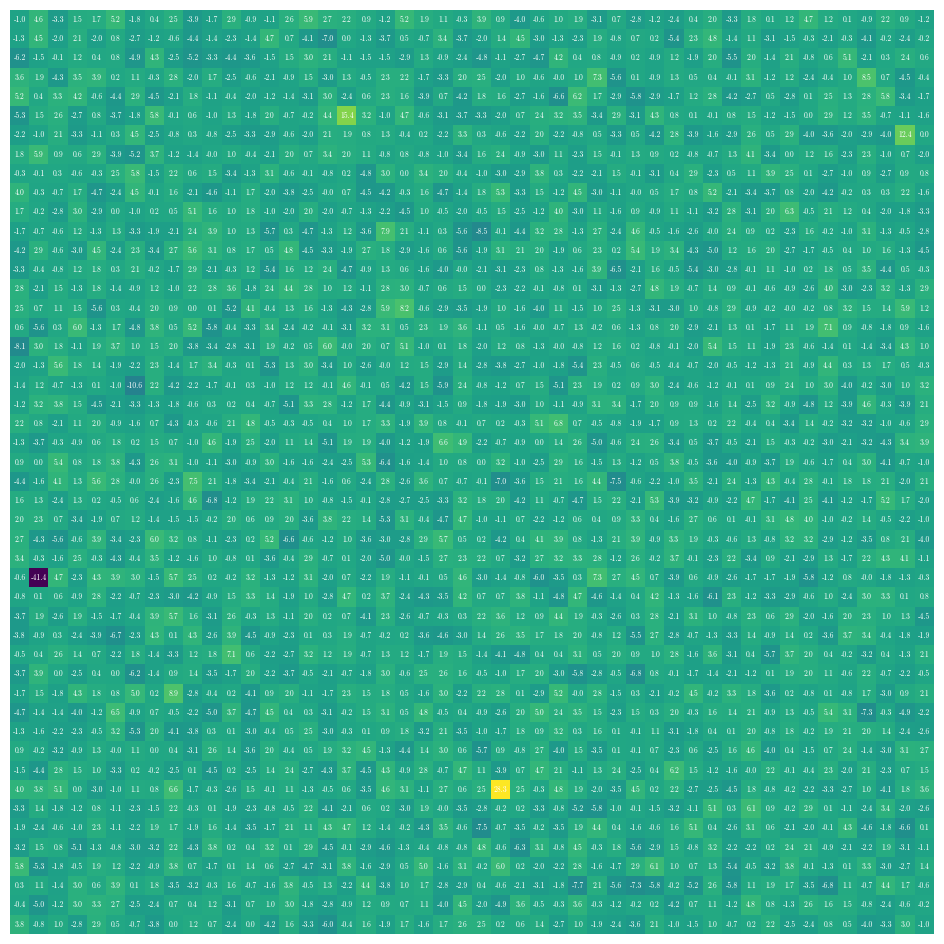

In [29]:
fig=plt.figure(0, (12,12))
ax=fig.add_subplot(111)
m=mlp_out[-1].reshape(48,48) #use mlp output to insepct activations

plt.imshow(m); 
#plt.colorbar()

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        ax.text(
            j, i, f"{m[i, j]:.1f}",
            ha="center", va="center",
            color="white", fontsize=5.5, 
            fontname="cmr10",
        )
plt.axis('off')
plt.savefig('/home/stephen/book_exports/7_mech_interp/layer_20_out.png', dpi=600, bbox_inches='tight')

In [30]:
mlp_out

array([[ 1.0767627 , -1.1226896 , -1.0095645 , ...,  0.11887094,
        -2.441758  , -1.2911003 ],
       [ 0.7809285 ,  0.43989193,  2.129242  , ..., -1.9305313 ,
         3.687842  , -0.85965353],
       [-4.452114  , -2.0047715 , -0.43601072, ..., -0.06355979,
         4.9726896 ,  2.1587849 ],
       ...,
       [-0.05223443, -2.399416  , -1.8376195 , ...,  1.8207339 ,
         2.5650384 ,  0.6445125 ],
       [-0.78648937,  2.007887  , -3.188151  , ..., -3.0958562 ,
         2.2215831 , -1.2087644 ],
       [-1.0060204 ,  4.5760202 , -3.2543743 , ..., -3.2594812 ,
         2.9713004 , -1.032637  ]], dtype=float32)

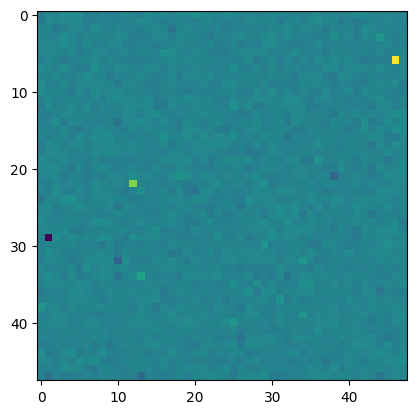

In [20]:
next_layer_normed=cache['blocks.'+str(21)+'.ln1.hook_normalized'][-1].detach().cpu().numpy().reshape(48,48) #After layernorm
plt.imshow(next_layer_normed)

In [46]:
# cache

## Steering

In [11]:
neuron_index=1393

In [12]:
def scale_hook(value, hook):
    value[:, :, neuron_index] = -160
    return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2263
 high 0.125
 much 0.1136
 low 0.0902
 questionable 0.0757
 good 0.0572
 poor 0.0366
 well 0.0226
 controversial 0.0196
 often 0.0138


In [13]:
def scale_hook(value, hook):
    value[:, :, neuron_index] = 160
    return value

logits = gemma_2_2b.run_with_hooks(tokens, fwd_hooks=[('blocks.20.hook_mlp_out', scale_hook)])
probs=logits[:,-1,:].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 much 0.1862
 important 0.151
 low 0.1136
 questionable 0.1066
 poor 0.0887
 high 0.0692
 good 0.0299
 often 0.0186
 well 0.0165
 dependent 0.0142


## SAE

In [14]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",
    sae_id="blocks.7.hook_resid_pre",
    latent_idx=0,
    width=1200,
    height=800,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))

def steering_hook(
    activations: Float[Tensor, "batch pos d_in"],
    hook: HookPoint,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
) -> Tensor:
    """
    Steers the model by returning a modified activations tensor, with some multiple of the steering vector added to all
    sequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx] #Hmm wow how can we visualize this - interesting. Pretty simple in a way.


def generate_with_steering( #Ah I could do a version of this for neurons - right!
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering. A multiple of the steering vector (the decoder weight for this latent) is added to
    the last sequence position before every forward pass.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )

    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        output = model.generate(prompt, max_new_tokens=max_new_tokens, **GENERATE_KWARGS)

    return output

In [15]:
_, cache = gemma_2_2b.run_with_cache_with_saes(prompt, saes=[gemma_2_2b_sae])

for name, param in cache.items():
    if "hook_sae" in name:
        print(f"{name:<43}: {tuple(param.shape)}")

blocks.20.hook_mlp_out.hook_sae_input      : (1, 7, 2304)
blocks.20.hook_mlp_out.hook_sae_acts_pre   : (1, 7, 16384)
blocks.20.hook_mlp_out.hook_sae_acts_post  : (1, 7, 16384)
blocks.20.hook_mlp_out.hook_sae_recons     : (1, 7, 2304)
blocks.20.hook_mlp_out.hook_sae_output     : (1, 7, 2304)


In [16]:
# Get top activations on final token
_, cache = gemma_2_2b.run_with_cache_with_saes(
    prompt,
    saes=[gemma_2_2b_sae],
    stop_at_layer=gemma_2_2b_sae.cfg.hook_layer + 1,
)
sae_acts_post = cache[f"{gemma_2_2b_sae.cfg.hook_name}.hook_sae_acts_post"][0, -1, :]

In [17]:
m=cache['blocks.20.hook_mlp_out.hook_sae_input']
# m=cache['blocks.20.attn.hook_z.hook_sae_input']
m.shape

torch.Size([1, 7, 2304])

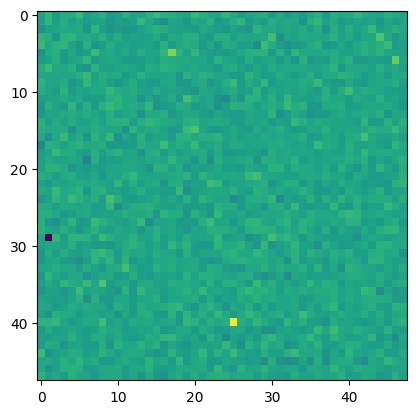

In [18]:
plt.imshow(m[0, -1, :].detach().cpu().numpy().reshape(48,48))

In [19]:
m=cache['blocks.20.hook_mlp_out.hook_sae_acts_post'].detach().cpu().numpy()
# m=cache['blocks.20.attn.hook_z.hook_sae_acts_post']
m.shape

(1, 7, 16384)

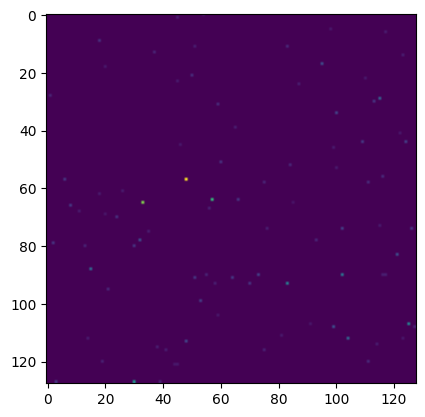

In [20]:
plt.imshow(m[0, -1, :].reshape(128,128))

In [21]:
top_indices = np.argsort(np.abs(m[0,-1]))[-10:][::-1]
m[0,-1][top_indices]

array([45.9957  , 37.256424, 30.383385, 23.406425, 19.714025, 18.762693,
       17.087051, 15.014446, 14.42557 , 13.609097], dtype=float32)

In [22]:
top_indices

array([ 7344,  8353,  8249, 16286, 13821, 11987, 11622, 11279, 14440,
        3827])

In [24]:
display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id, latent_idx=8249)

https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/8249?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [40]:
# for act, ind in zip(*sae_acts_post.topk(5)):
#     print(f"Latent {ind} had activation {act:.2f}")
#     # display_dashboard(latent_idx=ind)
#     display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id, latent_idx=ind)

Latent 7344 had activation 46.00
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/7344?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 8353 had activation 37.26
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/8353?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 8249 had activation 30.38
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/8249?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 16286 had activation 23.41
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/16286?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 13821 had activation 19.71
https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/13821?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [41]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)

In [42]:
# Test our prompt, to see what the model says
with gemma_2_2b.saes(saes=[gemma_2_2b_sae]):
    utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 2        Logit: 25.49 Prob: 12.46% Token: | high|

Top 0th token. Logit: 25.84 Prob: 17.56% Token: | important|
Top 1th token. Logit: 25.57 Prob: 13.51% Token: | much|
Top 2th token. Logit: 25.49 Prob: 12.46% Token: | high|
Top 3th token. Logit: 25.27 Prob: 10.01% Token: | low|
Top 4th token. Logit: 25.27 Prob:  9.98% Token: | questionable|
Top 5th token. Logit: 24.45 Prob:  4.41% Token: | poor|
Top 6th token. Logit: 24.39 Prob:  4.12% Token: | good|
Top 7th token. Logit: 23.68 Prob:  2.02% Token: | controversial|
Top 8th token. Logit: 23.57 Prob:  1.82% Token: | well|
Top 9th token. Logit: 23.27 Prob:  1.35% Token: | dependent|


Ranks of the answer tokens: [(' high', 2)]

In [43]:
latent_idx=8249

In [45]:
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=100,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
  utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 4        Logit: 23.42 Prob:  4.76% Token: | high|

Top 0th token. Logit: 24.88 Prob: 20.61% Token: | much|
Top 1th token. Logit: 24.80 Prob: 19.01% Token: | important|
Top 2th token. Logit: 24.77 Prob: 18.35% Token: | questionable|
Top 3th token. Logit: 23.44 Prob:  4.88% Token: | low|
Top 4th token. Logit: 23.42 Prob:  4.76% Token: | high|
Top 5th token. Logit: 22.82 Prob:  2.61% Token: | controversial|
Top 6th token. Logit: 22.75 Prob:  2.44% Token: | poor|
Top 7th token. Logit: 22.46 Prob:  1.83% Token: | good|
Top 8th token. Logit: 22.42 Prob:  1.76% Token: | often|
Top 9th token. Logit: 22.29 Prob:  1.54% Token: | debatable|


Ranks of the answer tokens: [(' high', 4)]

In [76]:
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=500,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
  utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 40       Logit: 16.76 Prob:  0.02% Token: | high|

Top 0th token. Logit: 24.68 Prob: 60.81% Token: | question|
Top 1th token. Logit: 23.35 Prob: 16.01% Token: | questioned|
Top 2th token. Logit: 22.87 Prob:  9.97% Token: | into|
Top 3th token. Logit: 21.96 Prob:  3.99% Token: | questionable|
Top 4th token. Logit: 21.06 Prob:  1.63% Token: | Question|
Top 5th token. Logit: 20.72 Prob:  1.16% Token: | open|
Top 6th token. Logit: 20.71 Prob:  1.15% Token: | disputed|
Top 7th token. Logit: 19.83 Prob:  0.47% Token: | serious|
Top 8th token. Logit: 19.81 Prob:  0.47% Token: | much|
Top 9th token. Logit: 19.78 Prob:  0.45% Token: | debatable|


Ranks of the answer tokens: [(' high', 40)]

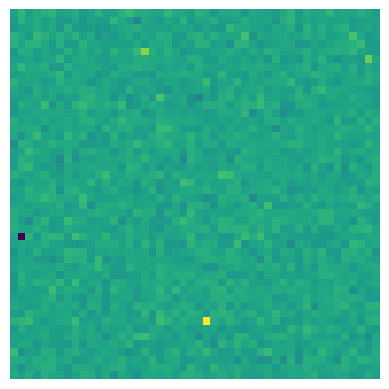

In [74]:
mlp_out=cache['blocks.'+str(20)+'.hook_mlp_out.hook_sae_output'][0, -1].detach().cpu().numpy()
plt.imshow(mlp_out.reshape(48,48)); plt.axis('off')
plt.savefig('/home/stephen/book_exports/7_mech_interp/post_sae_layer_20_mlp.png', dpi=600, bbox_inches='tight')